# Lesson 9: Memories

## Intro to Quantified Cognition

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2022_Fall/notebooks/09_Memories.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- Introduce some ways memory can be probed
- Categorical Continuous Recognition
- Identify cool behavioral pattern of interest
- Build-a-Model!!!
- See if we can recreate that cool pattern of interest
  - (Pssssst, the answer is kinda yes!)


## How can we test episodic memory?

- **Free recall**
  - Study a list of items and then recall them in any order you like
- **Serial recall**
  - Study a list of items and then recall them in a specific order
- **Cued recall**
  - Study pairs of items and recall one item when cued with the other
- **Item recognition**
  - Study a list of items and then identify studied vs. novel items
- **Associative recognition**
  - Study pairs of items and then identify studied vs. novel (new or rearranged) items
- **Judgment of recency**
  - Study items and then identify which of two items occurred more recently


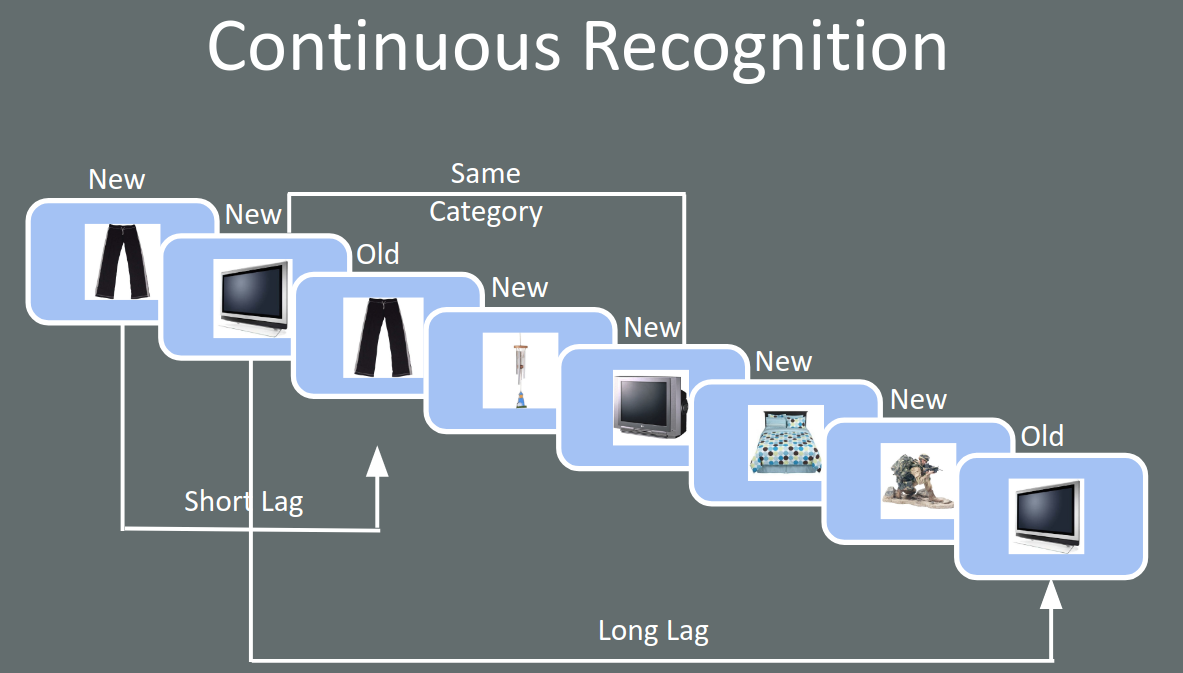

## Signal Detection Theory --- Strength Theory of Memory

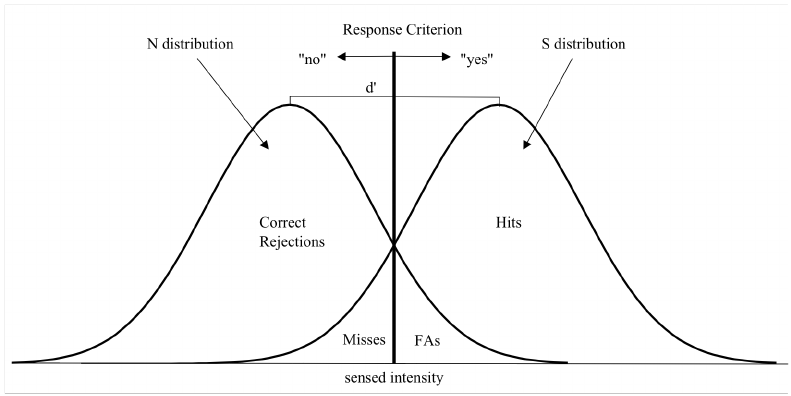


## Let's explore the data!!!

In [ ]:
# to install RunDEMC
!pip install git+https://github.com/compmem/RunDEMC.git --upgrade


## *ONLY* if on Google Colab

In [ ]:
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/2022_fall/notebooks/CCR_quantcog.csv
#!wget https://raw.githubusercontent.com/compmem/QuantCog/2022_fall/notebooks/CatCR_s10_burn_rho.pickle.gz

In [ ]:
# to install more libraries
!pip install KDEpy
!pip install arviz

## Load modules of power

In [165]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
#import plotnine as pn
import arviz as az
from sklearn.preprocessing import OneHotEncoder

from RunDEMC.density import kdensity
from RunDEMC import Model, Param, dists, calc_bpic, joint_plot
from RunDEMC.pda import PDA
from RunDEMC.io import arviz_dict, load_results
from RunDEMC import Hierarchy, HyperPrior, NormalHyperPrior

from joblib import Parallel, delayed


## Load in the data

In [3]:
# import data
df_all = pd.read_csv('CCR_quantcog.csv', index_col=0)
subs = np.unique(df_all['subj'])
df_all.head()



,appear_time_error,appear_time_time,base_time,block_num,cat,condition,correct,correct_resp,date,lag,...,rt,run_num,stim,trial_num,subj,datetime,press_time,passed,cat_obj_nums,cat_trial_nums
0,0,178101.3885,NaN,0,lantern,new,NaN,H,6/9/2017,1,...,NaN,0,/sdcard/smile_images/17-objects/lantern/lanter...,0,1,20170609_111649,NaN,1,1,1
1,0,178104.0019,178104.1878,0,lantern,old,0.0,G,6/9/2017,1,...,0.645822,0,/sdcard/smile_images/17-objects/lantern/lanter...,1,1,20170609_111649,NaN,1,1,2
2,0,178106.4705,178106.6570,0,saltpeppershake,new,1.0,H,6/9/2017,9,...,0.932769,0,/sdcard/smile_images/17-objects/saltpeppershak...,2,1,20170609_111649,NaN,1,1,1
3,0,178109.1085,178109.2959,0,balloon,new,1.0,H,6/9/2017,6,...,0.870521,0,/sdcard/smile_images/17-objects/balloon/ABALLO...,3,1,20170609_111649,NaN,1,1,1
4,0,178111.5771,178111.7734,0,juice,new,1.0,H,6/9/2017,9,...,0.690777,0,/sdcard/smile_images/17-objects/juice/XB0EO.jpg,4,1,20170609_111649,NaN,1,1,1


In [4]:
len(df_all.cat.unique())

200

In [5]:
df_all.cat.unique()

array(['lantern', 'saltpeppershake', 'balloon', 'juice', 'tongs',
       'cheesegrater', 'camera', 'nunchaku', 'binoculars', 'bearteddy',
       'phone', 'coffeemug', 'windchime', 'apple', 'dollhouse',
       'easteregg_redo', 'donut', 'grill', 'radio', 'magazinecovers',
       'videoGameController', 'bowl', 'necklace', 'mp3player',
       'exercise_equipment', 'bowtie', 'cupsaucer', 'yarn', 'cake',
       'goggle', 'tape', 'speakers', 'handbag', 'backpack', 'keyboard',
       'ball', 'armyguy', 'compass', 'doll', 'key', 'flashlight',
       'toyrabbit', 'airplane', 'guitar', 'collar', 'nailpolish', 'boot',
       'toothpaste', 'domino', 'roadsign', 'bottle', 'cookie', 'handgun',
       'leaves', 'bird', 'basket', 'baseballcards', 'lamp',
       'beanbagchair', 'frisbee', 'toiletseat', 'abacus', 'golfball',
       'muffins', 'tree', 'tent', 'cherubstatue',
       'candleholderwithcandle', 'spoon', 'scale', 'trunk', 'headband',
       'pipe', 'ceilingfan', 'axe', 'lei', 'bucket', 'keych

## Some analysis scripts from my postdoc (Kevin Darby)

In [6]:

# Analysis code from Kevin Darby
def make_metric(df, min_rt = .35, max_rt = 2., acc_col = 'correct', rt_col = 'rt'):
    # calculate a metric score
    mask = (df[rt_col] > min_rt) & (df[rt_col] < max_rt)
    corr_trials = df.loc[mask, acc_col]
    rt_trials = df.loc[mask, rt_col]
    
    num_trials = mask.sum() #df[mask].shape[0]
    if num_trials > 0:
        avec=((np.sum(corr_trials)/float(num_trials))-.5)/.5
        rvec=(np.sum([(np.log(max_rt+1.)-np.log(r+1.))/((np.log(max_rt+1.)-np.log(min_rt+1.)))
                    for r in rt_trials])/num_trials)
        score = avec*rvec
    else:
        avec = np.nan
        rvec = np.nan
        score = np.nan
    return avec, rvec, score

def get_Az(hr, far, n_h, n_f):

    hr_trans = ((hr*n_h)+.5)/(n_h+1)
    far_trans = ((far*n_f)+.5)/(n_f+1)
    Z = stats.norm.ppf
    d = Z(hr_trans) - Z(far_trans)
    Az = stats.norm.cdf(d/np.sqrt(2))

    return d, Az



In [10]:
# More code from Kevin Darby
categ_nums = [1,2]

dats = {'subject': [], 'categ_num': [], 'lag': [], 
        'd': [], 'hr': [], 'far': [], 'metric': []}

for sub in subs:
    df_sub = df_all[df_all['subj'] == sub]
    
    for num in categ_nums:
        df_num = df_sub[df_sub['cat_obj_nums'] == num]
        lags = df_num['lag'].unique()
        lags.sort()
        for lag in lags:
            this_df = df_num[df_num['lag'] == lag]

            new = this_df[this_df['condition'] == 'new']
            old = this_df[this_df['condition'] == 'old']

            # Number of old and new trials
            n_h = old.shape[0]
            n_f = new.shape[0]

            if n_h > 0 and n_f > 0:

                # Hit and false alarm rates
                hr = old[old['correct'] == 1].shape[0] / n_h
                far = new[new['correct'] == 0].shape[0] / n_f

                # Calculate d' and A_z
                d, Az = get_Az(hr, far, n_h, n_f)

            else:
                d = np.nan
                Az = np.nan
                hr = np.nan
                far = np.nan

            # calculate the metric score
            avec, rvec, score = make_metric(this_df, min_rt = .35, max_rt = 2., 
                                            acc_col = 'correct', rt_col = 'rt')
            
            # append the values
            dats['subject'].append(sub)
            dats['categ_num'].append(num)
            dats['lag'].append(lag)
            dats['d'].append(d)
            dats['hr'].append(hr)
            dats['far'].append(far)
            dats['metric'].append(score)
            
dats_df = pd.DataFrame(dats)
dats_df.head()

,subject,categ_num,lag,d,hr,far,metric
0,1,1,1,3.175434,0.843137,0.009804,0.758179
1,1,1,2,3.413044,0.885965,0.008772,0.755274
2,1,1,4,3.500638,0.857143,0.000000,0.710075
3,1,1,5,3.642397,0.881579,0.000000,0.768340
4,1,1,6,3.017401,0.842857,0.014286,0.720844


## Plot some behavioral summaries

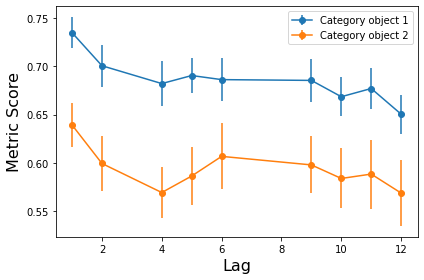

In [20]:
# plot metric as a function of lag and category
for num in [1, 2]:
    this_df = dats_df[dats_df['categ_num'] == num]
    lags = this_df['lag'].unique()
    lags.sort()

    means = [np.mean(this_df[this_df['lag'] == lag]['metric']) for lag in lags]
    sems = [stats.sem(this_df[this_df['lag'] == lag]['metric']) for lag in lags]
    
    ax = plt.gca()
    plt.errorbar(lags, means, sems, fmt='o-', 
                 label='Category object %s' % num)

    plt.ylabel('Metric Score', fontsize = 16)
    plt.xlabel('Lag', fontsize = 16)
    
plt.legend();

plt.tight_layout()

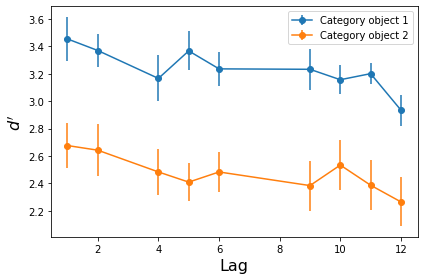

In [19]:
# plot d' as a function of lag and category
for num in [1, 2]:
    this_df = dats_df[dats_df['categ_num'] == num]
    lags = this_df['lag'].unique()
    lags.sort()

    means = [np.mean(this_df[this_df['lag'] == lag]['d']) for lag in lags]
    sems = [stats.sem(this_df[this_df['lag'] == lag]['d']) for lag in lags]
    
    ax = plt.gca()
    plt.errorbar(lags, means, sems, fmt='o-', 
                 label='Category object %s' % num)

    plt.ylabel(r"$d'$", fontsize = 16)
    plt.xlabel('Lag', fontsize = 16)
    
plt.legend();

plt.tight_layout()

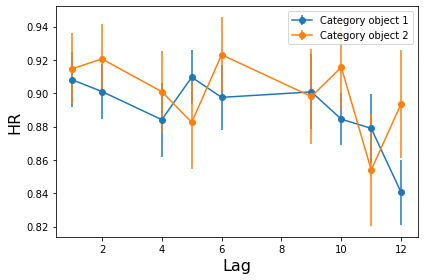

In [163]:
# plot HR as a function of lag and category
for num in [1, 2]:
    this_df = dats_df[dats_df['categ_num'] == num]
    lags = this_df['lag'].unique()
    lags.sort()

    means = [np.mean(this_df[this_df['lag'] == lag]['hr']) for lag in lags]
    sems = [stats.sem(this_df[this_df['lag'] == lag]['hr']) for lag in lags]
    
    ax = plt.gca()
    plt.errorbar(lags, means, sems, fmt='o-', 
                 label='Category object %s' % num)

    plt.ylabel('HR', fontsize = 16)
    plt.xlabel('Lag', fontsize = 16)
    
plt.legend();

plt.tight_layout()


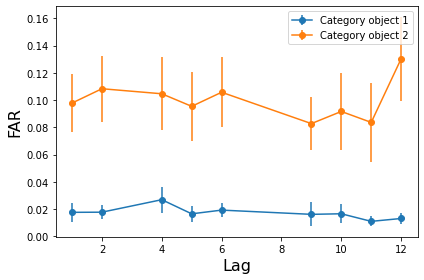

In [161]:
# plot FAR as a function lag and category
for num in [1, 2]:
    this_df = dats_df[dats_df['categ_num'] == num]
    lags = this_df['lag'].unique()
    lags.sort()

    means = [np.mean(this_df[this_df['lag'] == lag]['far']) for lag in lags]
    sems = [stats.sem(this_df[this_df['lag'] == lag]['far']) for lag in lags]
    
    ax = plt.gca()
    plt.errorbar(lags, means, sems, fmt='o-', 
                 label='Category object %s' % num)

    plt.ylabel('FAR', fontsize = 16)
    plt.xlabel('Lag', fontsize = 16)
    
plt.legend();

plt.tight_layout()


## Temporal Context Model of CCR

In [107]:
# add in some key columns

# whether they said old (2), new (1), or neither (0)
df_all['resp'] = 0
has_resp = ~df_all.pressed.isna()
df_resp = df_all.loc[has_resp]
df_resp.loc[(((df_resp.correct==1) & (df_resp.condition=='old')) |
             ((df_resp.correct==0) & (df_resp.condition=='new'))), 'resp'] = 2
df_resp.loc[(((df_resp.correct==1) & (df_resp.condition=='new')) |
             ((df_resp.correct==0) & (df_resp.condition=='old'))), 'resp'] = 1
df_all.loc[has_resp, 'resp'] = df_resp.resp
df_all.resp.unique()


array([0, 1, 2])

## We need some way to turn a list of stimuli into item vectors

array([2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. ,
       2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. ,
       2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 1.2, 2.4, 2.4,
       2.4, 1.2, 2.4, 1.2, 2.4, 1.2, 1.2, 2.4, 1.2, 1.2, 2.4, 1.2, 1.2,
       1.2, 1.2, 1.2, 1.2, 1.2, 2.4, 1.2, 1.2, 1.2, 2.4, 1.2, 0. ])

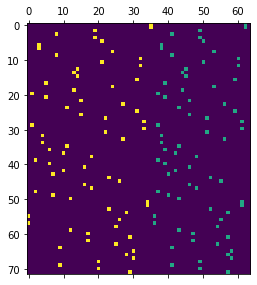

In [131]:
def list_to_items(df, stim_val=1.0, cat_val=1.0):
    """Convert a list into item vectors"""
    # encode them as one-hot vectors
    cats = OneHotEncoder().fit_transform(np.array(df.cat).reshape((-1,1))).toarray()
    ncats = cats.shape[1]
    objs = OneHotEncoder().fit_transform(np.array(df.stim).reshape((-1,1))).toarray()
    nobjs = objs.shape[1]
    
    # concatenate them (and add in starting context)
    init_column = np.zeros((len(objs), 1))
    items = np.hstack([objs*stim_val, cats*cat_val, init_column])
    obj_inds = np.zeros(items.shape[1], dtype=bool)
    obj_inds[:nobjs] = True
    cat_inds = np.zeros(items.shape[1], dtype=bool)
    cat_inds[nobjs:nobjs+ncats] = True

    # return items
    return items, obj_inds, cat_inds

# test it out on a session from one subj
subj_num = 10
df = df_all.loc[df_all.subj == subj_num]
sessions = df.datetime.unique()
df = df.loc[df.datetime==sessions[-1]]

items, obj_inds, cat_inds = list_to_items(df, stim_val=1.0, cat_val=.6)
plt.matshow(items)
items.sum(0)

## Let's build our temporal context model!

In [152]:
# function to simulate a CatContRecog list
def simulate_list(df, stim_val=1.0, cat_val=1.0, rho=0.5, beta=0.5,
                  alpha=1.0, tau=1.0, lam=1.0, nu=1.0, rho_cat=None):
    
    # process the rho_cat
    if rho_cat is None:
        # set it to rho
        rho_cat = rho

    # set up items and context vectors
    num_stim = len(df.stim.unique())
    num_cat = len(df.cat.unique())
    items, obj_inds, cat_inds = list_to_items(df, 
                                              stim_val=stim_val, 
                                              cat_val=cat_val)

    # use the last unit as the starting state of context 
    # (orthogonal to everything else)
    t0 = np.zeros(items.shape[1])
    t0[-1] = 1.0

    # set up empty memory matrix
    M = np.zeros((items.shape[1], items.shape[1]))

    # loop over the items presenting them to the model
    log_likes = []
    r_save = []
    t_save = []
    p_old_save = []
    for i,f1 in enumerate(items):
        # Calc overall strength
        # readout of the item from context 
        # (ignoring starting unit)
        fc = np.dot(f1, t0)
        
        # reinstated context
        tr = np.dot(f1, M)
        
        # items predicted from that reinstated context
        fr = np.dot(M, tr)
        
        # difference of current context and reinstated context
        #tdiff = tr-t0
        
        # overall item strength
        #s = lam*((1-beta)*fc + beta*(np.dot(tr, t0) - np.dot(tdiff, tdiff)))
        #s = lam*((1-beta)*fc + beta*np.dot(tr, t0))
        #s = lam*((1-beta)*fc + beta*np.dot(f1, np.dot(M, tr)))
        s = np.float128(lam*((beta)*fc + np.dot(f1, fr)))

        # Calc the prob of making an old response
        p_old = np.float64(np.exp(tau*s) / (np.exp(tau*s)+np.exp(tau*nu)))
        p_old_save.append(p_old)
        
        # pick matching response prob
        act_resp = df.iloc[i]['resp']
        if act_resp == 1:
            # must flip to make it p_new
            p_resp = 1-p_old
        elif act_resp == 2:
            # just use the p_old
            p_resp = p_old

        if act_resp != 0:
            # only save if they made a response
            if p_resp == 0:
                log_likes.append(-np.inf)
            else:
                log_likes.append(np.log(p_resp))
        else:
            log_likes.append(np.nan)

        # calculate novelty (r) from strength
        s_r = np.float128(s - nu)
        r = np.exp(-s_r)/(1+np.exp(-s_r))
        #r = np.exp(-fr)
        r_save.append(r)

        # update context (adding empty starting context unit)
        t1 = (1-rho*r)*t0 + (rho*r)*f1
        
        # update the cat at different rate
        t1[cat_inds] = (1-rho_cat*r)*t0[cat_inds] + (rho_cat*r)*f1[cat_inds]
        t_save.append(t1)
            
        # update M (associate the item and the context)
        M += r*alpha*np.outer(f1, t0)

        # prepare context for next item
        t0 = t1.copy()

    return {'log_likes': log_likes, 'p_old': p_old_save, 'r': r_save,
            't': t_save, 'M': M}

## We have a model, so let's fit it to data

In [155]:
# define a likelihood function
def like_fun(pop, *args):
    # grab the data
    df = args[0]
    param_names = pop.dtype.names
    
    # loop over pop and eval the likes
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # eventually loop over lists here
        res = simulate_list(df, **dict(zip(param_names, p)))
        likes[i] += np.nansum(res['log_likes'])
        if likes[i] == -np.inf:
            continue

    return likes

In [156]:
df_all.subj.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18])

In [158]:
# pick some data
subj_num = 10
df = df_all.loc[df_all.subj == subj_num]

# set up hyper priors
param_names = ['cat_val', 'rho', 'rho_cat', 'beta', 'alpha', 'lam', 'tau', 'nu']
hypers = {name: NormalHyperPrior('h_'+name, mu=0, sigma=1, alpha=3, beta=1)
          #HyperPrior('h_'+name,
                #           dists.normal,
                #           params=[Param(name='mu', prior=dists.normal(0, 1)),
                #                   Param(name='sig', prior=dists.halfcauchy(1.0),
                #                         init_prior=dists.uniform(0.5, 1.4))])
          for name in param_names}

# loop over sessions
smods = {}
sessions = df.datetime.unique()[3:4]
print('Num. Sessions:', len(sessions))
for dt in sessions:
    # set up params
    params = [Param(name='cat_val', prior=hypers['cat_val'], 
                    transform=lambda x: dists.invlogit(x)),
              Param(name='rho', prior=hypers['rho'], 
                    transform=lambda x: dists.invlogit(x)),
              Param(name='rho_cat', prior=hypers['rho'], 
                    transform=lambda x: dists.invlogit(x)),
              Param(name='beta', prior=hypers['beta'], 
                    transform=lambda x: dists.invlogit(x)),
              Param(name='alpha', prior=hypers['alpha'], 
                    transform=lambda x: dists.invlogit(x)*10),
              Param(name='lam', prior=hypers['lam'], 
                    transform=lambda x: dists.invlogit(x)*10),
              Param(name='tau', prior=hypers['tau'], 
                    transform=lambda x: dists.invlogit(x)*5),
              Param(name='nu', prior=hypers['nu'], 
                    transform=lambda x: dists.invlogit(x)*10)]

    # make the model
    smods[dt] = Model(dt, params=params,
                      like_fun=like_fun,
                      like_args=(df.loc[df.datetime == dt],),
                      #pop_parallel=True,
                      verbose=False)

parallel = Parallel(n_jobs=-1, verbose=0)
hmod = Hierarchy(smods.values(), parallel=parallel)

Num. Sessions: 1


In [159]:
hmod.sample(25, burnin=True)
#hmod.sample(600, burnin=False)
hmod.save('CatCR_s%d_burn_rho.pickle.gz'%(subj_num))

Max Group Size: 160
Processing params (1): 1 
Linking models (7): 1 2 3 4 5 6 7 
Initializing (8): 160(160) 109(109) 70(70) 48(48) 33(33) 22(22) 11(11) 6(6) 6(6) 3(3) 2(2) 1(1) 1(1) 1(1) Iterations (25): 

KeyboardInterrupt: 

In [96]:
dtkey = list(smods.keys())[8]
m = smods[dtkey]

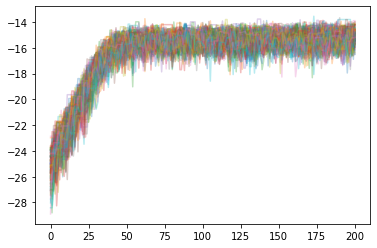

In [97]:
plt.plot(m.weights[20:, :], alpha=0.3);

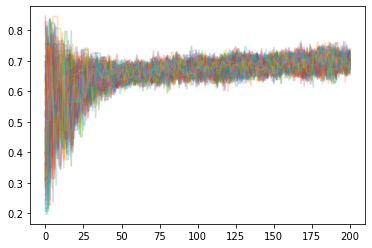

In [98]:
plt.plot(m.particles[20:, :, 1], alpha=0.3);

In [99]:
print("Best fitting params:")
burnin=20
best_ind = m.log_likes[burnin:].argmax()
print("Weight:", m.log_likes[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: -12.908471048097812
"cat_val": 0.730824,
"rho": 0.568041,
"rho_cat": 0.478686,
"beta": 0.647160,
"alpha": 0.821137,
"lam": 5.913520,
"tau": 2.079049,
"nu": 1.414418,


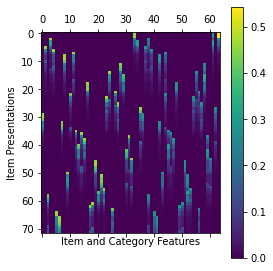

In [85]:
plt.matshow(np.array(res['t']))
plt.xlabel('Item and Category Features')
plt.ylabel('Item Presentations')
plt.colorbar()

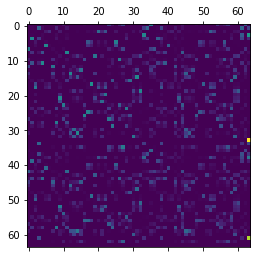

In [86]:
plt.matshow(np.array(res['M']))

Text(0, 0.5, 'P(old)')

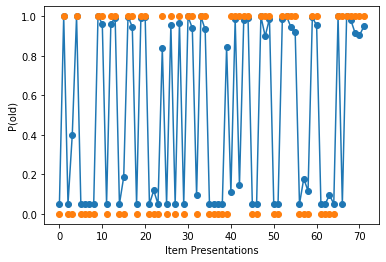

In [87]:
resps = df.loc[df.datetime==dtkey, 'resp'].values

plt.plot(res['p_old'], '-o')
plt.plot(resps-1, 'o')
plt.xlabel('Item Presentations')
plt.ylabel('P(old)')

Text(0, 0.5, 'Novelty Signal')

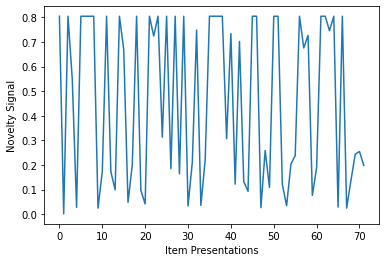

In [88]:
plt.plot(res['r'])
plt.xlabel('Item Presentations')
plt.ylabel('Novelty Signal')

## Let's look at Observed and Predicted Performance for a subj

In [166]:
def get_best_fit_params(m, burnin=20):
    best_ind = m['log_likes'][burnin:].argmax()
    indiv = [m['particles'][burnin:,:,i].ravel()[best_ind] 
             for i in range(m['particles'].shape[-1])]
    pp = dict(zip(m['param_names'], indiv))
    return pp

In [173]:
# simulate a subj with their best-fitting params for each list
subj_num = 10
df = df_all.loc[df_all.subj == subj_num]
hres = load_results('CatCR_s%d_burn_rho.pickle.gz'%subj_num)

# loop over sessions
sessions = df.datetime.unique()
perf = []
for sess in sessions:
    # grab the data for that session
    dfs = df.loc[df.datetime==sess]
    
    # get best-fitting params for that session
    pp = get_best_fit_params(hres[sess])
    
    # simulate the model
    res = simulate_list(dfs, **pp)

    # extract actual and predicted perf at each lag
    for lag in dfs.lag_name.unique():
        # loop over cat_obj_nums
        for cnum in dfs.cat_obj_nums.unique():
            # calc the observed and predicted hit rates
            ind = (dfs.lag_name==lag)&(dfs.condition=='old')&(dfs.cat_obj_nums==cnum)
            oHR = (dfs.loc[ind, 'correct'].dropna()==1.0).mean()
            pHR = np.nanmean(np.array(res['p_old'])[ind])

            # calc the observed and predicted false alarm rates
            ind = (dfs.lag_name==lag)&(dfs.condition=='new')&(dfs.cat_obj_nums==cnum)
            oFAR = (dfs.loc[ind, 'correct'].dropna()==0.0).mean()
            pFAR = np.nanmean(np.array(res['p_old'])[ind])

            # add in the results
            perf.append({'subject': subj_num,
                         'session': sess,
                         'lag': lag,
                         'lag_mean': dfs.loc[dfs.lag_name==lag, 'lag'].mean(),
                         'cat_num': cnum,
                         'cond': 'obs',
                         'HR': oHR,
                         'FAR': oFAR,
                        })
            perf.append({'subject': subj_num,
                         'session': sess,
                         'lag': lag,
                         'lag_mean': dfs.loc[dfs.lag_name==lag, 'lag'].mean(),
                         'cat_num': cnum,
                         'cond': 'pred',
                         'HR': pHR,
                         'FAR': pFAR,
                        })

df_res = pd.DataFrame(perf)
df_res.head()

,subject,session,lag,lag_mean,cat_num,cond,HR,FAR
0,10,20171001_192907,short,1.50,1,obs,0.666667,0.000000
1,10,20171001_192907,short,1.50,1,pred,0.807101,0.092327
2,10,20171001_192907,short,1.50,2,obs,1.000000,0.500000
3,10,20171001_192907,short,1.50,2,pred,0.904503,0.133991
4,10,20171001_192907,long,10.75,1,obs,0.888889,0.000000


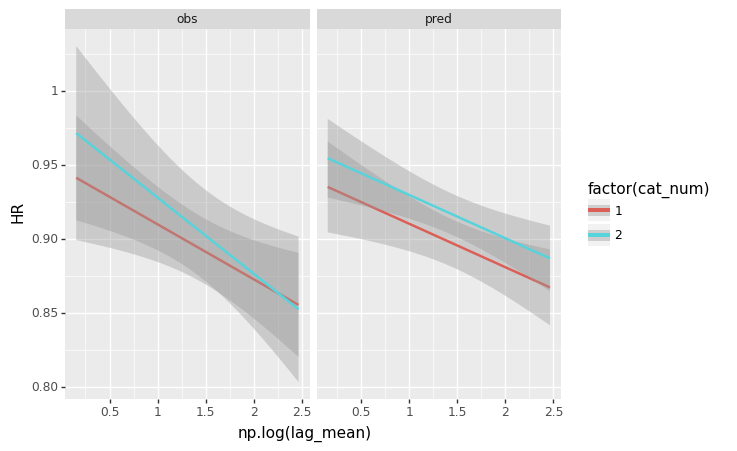

<ggplot: (8791066662205)>

In [174]:
import plotnine as pn

# plot the observed and predicted Hit Rates
(pn.ggplot(df_res, pn.aes(x='np.log(lag_mean)', y='HR', 
                          color='factor(cat_num)'))
 + pn.geom_smooth(method='glm') + pn.facet_wrap('cond'))

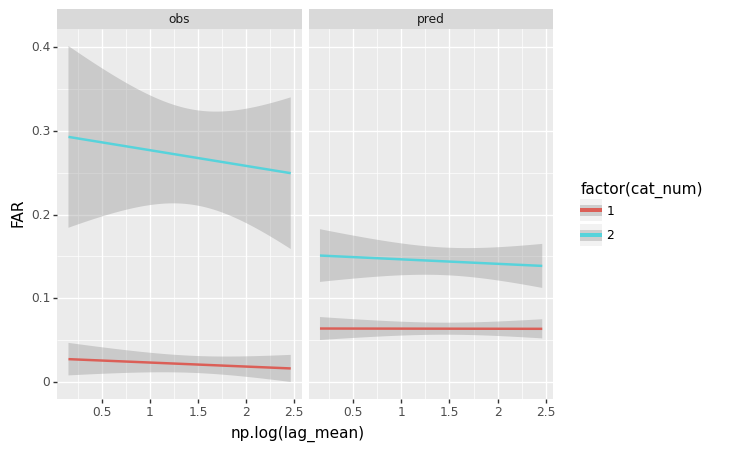

<ggplot: (8791066540843)>

In [175]:
# plot the observed and predicted False Alarm Rates
(pn.ggplot(df_res, pn.aes(x='np.log(lag_mean)', y='FAR', 
                          color='factor(cat_num)'))
 + pn.geom_smooth(method='glm') + pn.facet_wrap('cond'))

## Huzzah!?!